# TCAV Analysis: All Layers Comparison

Comparing **stem, stage0-5** layers to find which best captures speaker identity through acoustic concepts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
print("Ready!")

Ready!


In [2]:
PROJECT_ROOT = Path.cwd().parents[2]
sys.path.append(str(PROJECT_ROOT))
print("PROJECT_ROOT =", PROJECT_ROOT)


csv_path = Path(PROJECT_ROOT / "data" / "tcav" / "tcav_real_vs_fake_all_layers.csv")

PROJECT_ROOT = /home/SpeakerRec/BioVoice


In [3]:
# Load data
df = pd.read_csv(csv_path)
print(f"Total rows: {len(df)}")
print(f"Layers: {df['layer_key'].unique()}")
print(f"Speakers: {df['true label'].unique()}")
print(f"Concepts: {df['concept name'].nunique()}")

Total rows: 5040
Layers: ['stage4' 'stage5']
Speakers: [0 1]
Concepts: 14


In [4]:
# Prepare data per layer
def get_layer_data(df, layer):
    layer_df = df[df['layer_key'] == layer]
    vector_df = layer_df.pivot_table(
        index=['path', 'true label'],
        columns='concept name',
        values='magnitude'
    ).reset_index()
    concept_cols = [c for c in vector_df.columns if c not in ['path', 'true label']]
    X = vector_df[concept_cols].values
    y = vector_df['true label'].values
    return X, y, concept_cols, vector_df

# layers = ['stem', 'stage0', 'stage1', 'stage2', 'stage3', 'stage4', 'stage5']
layers = ['stage4', 'stage5']
layer_data = {}
for layer in layers:
    X, y, concepts, vector_df = get_layer_data(df, layer)
    layer_data[layer] = {'X': X, 'y': y, 'concepts': concepts, 'df': vector_df}
    print(f"{layer}: {X.shape[0]} samples, {X.shape[1]} concepts")

stage4: 180 samples, 14 concepts
stage5: 180 samples, 14 concepts


---
# Section 1: Speaker-Concept Heatmaps per Layer

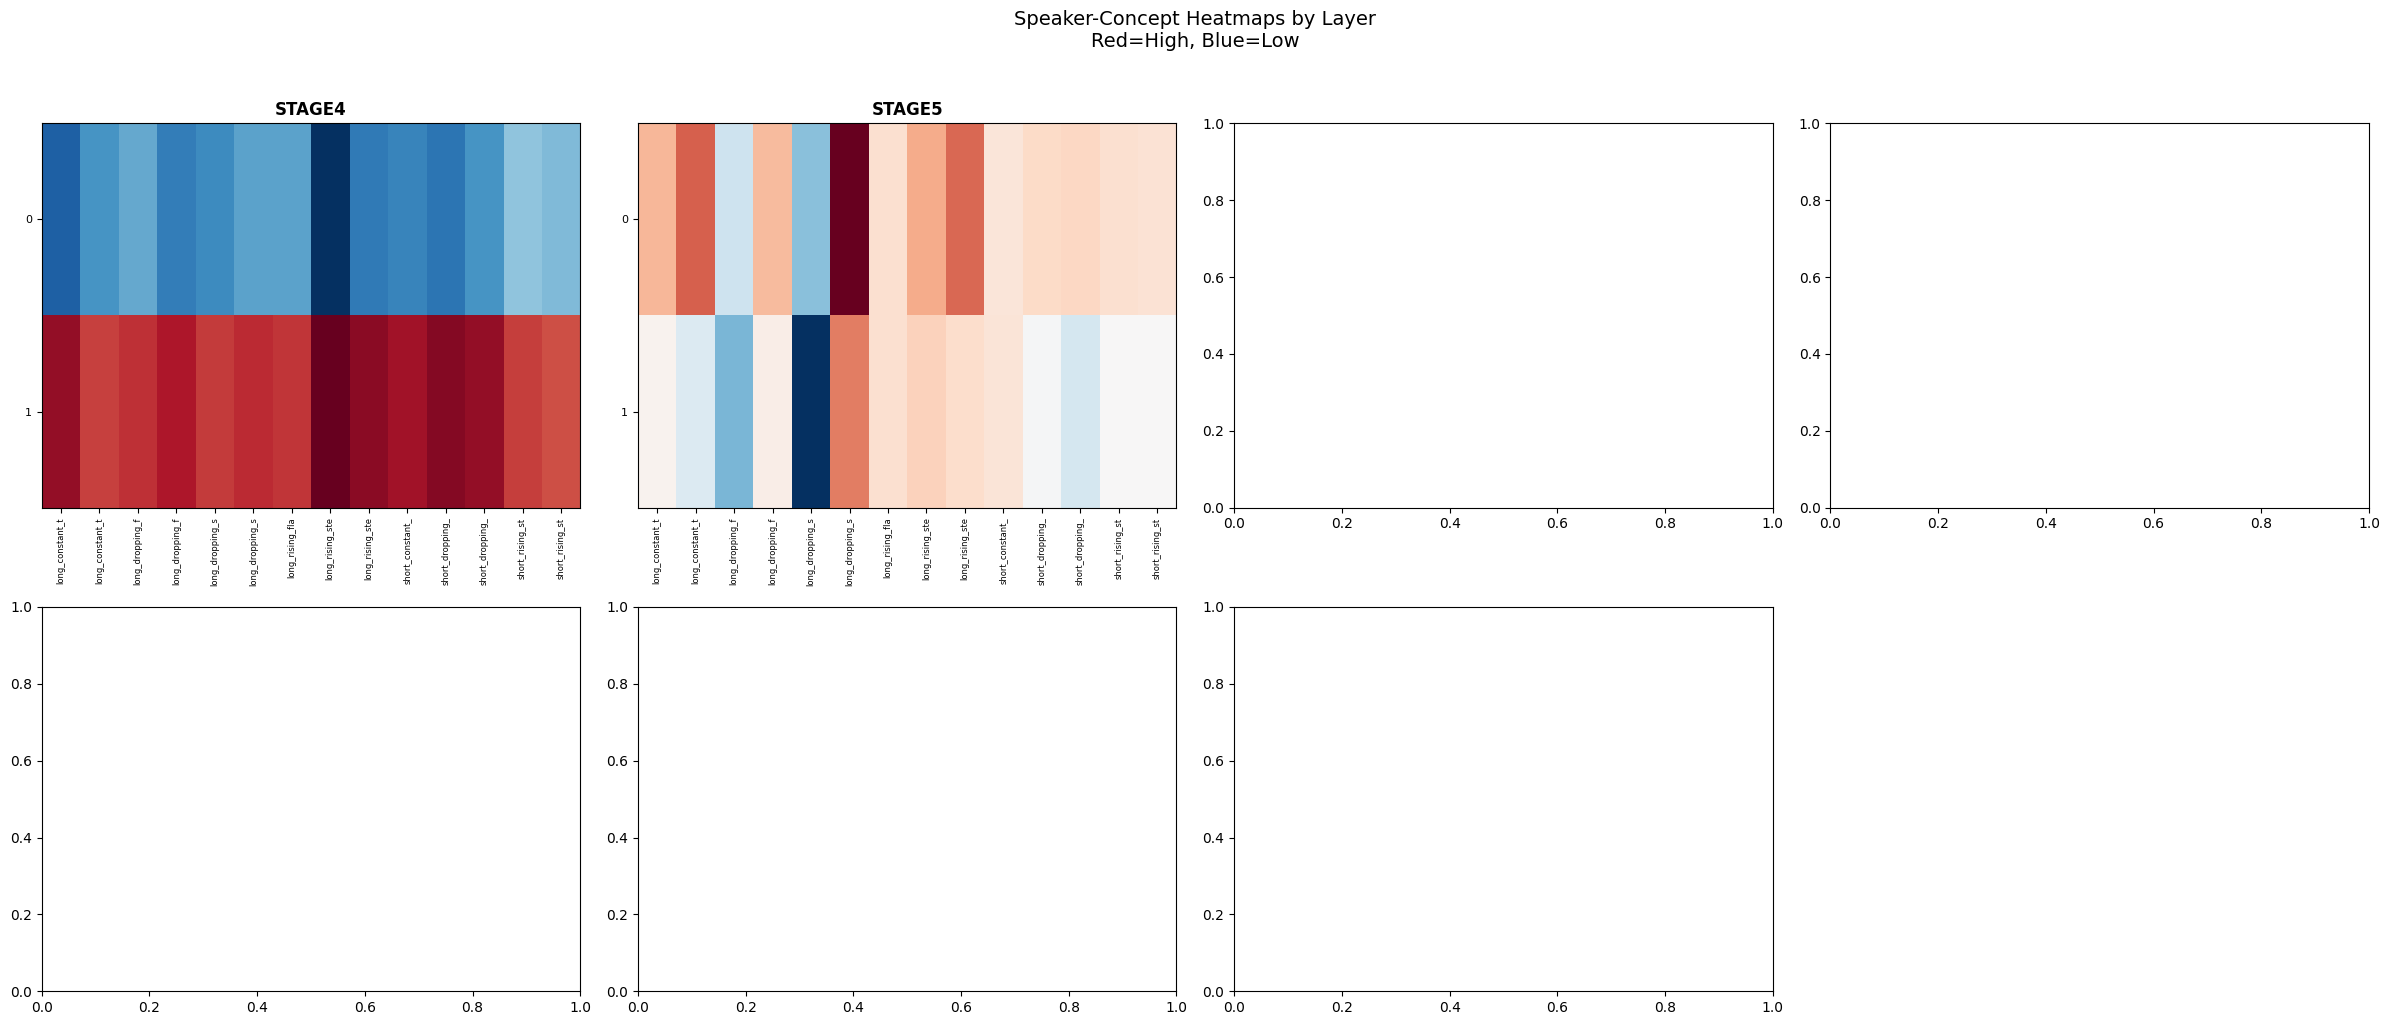

In [5]:
# Heatmaps for all layers
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

for idx, layer in enumerate(layers):
    vector_df = layer_data[layer]['df']
    table = vector_df.drop(columns=['path']).groupby('true label').mean()
    
    ax = axes[idx]
    im = ax.imshow(table.values, cmap='RdBu_r', aspect='auto')
    ax.set_xticks(np.arange(len(table.columns)))
    ax.set_yticks(np.arange(len(table.index)))
    ax.set_xticklabels([c[:15] for c in table.columns], fontsize=6, rotation=90)
    ax.set_yticklabels(table.index, fontsize=8)
    ax.set_title(f'{layer.upper()}', fontsize=12, fontweight='bold')

axes[-1].set_visible(False)  # Hide extra subplot
plt.suptitle('Speaker-Concept Heatmaps by Layer\nRed=High, Blue=Low', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
# Section 2: PCA Visualization per Layer

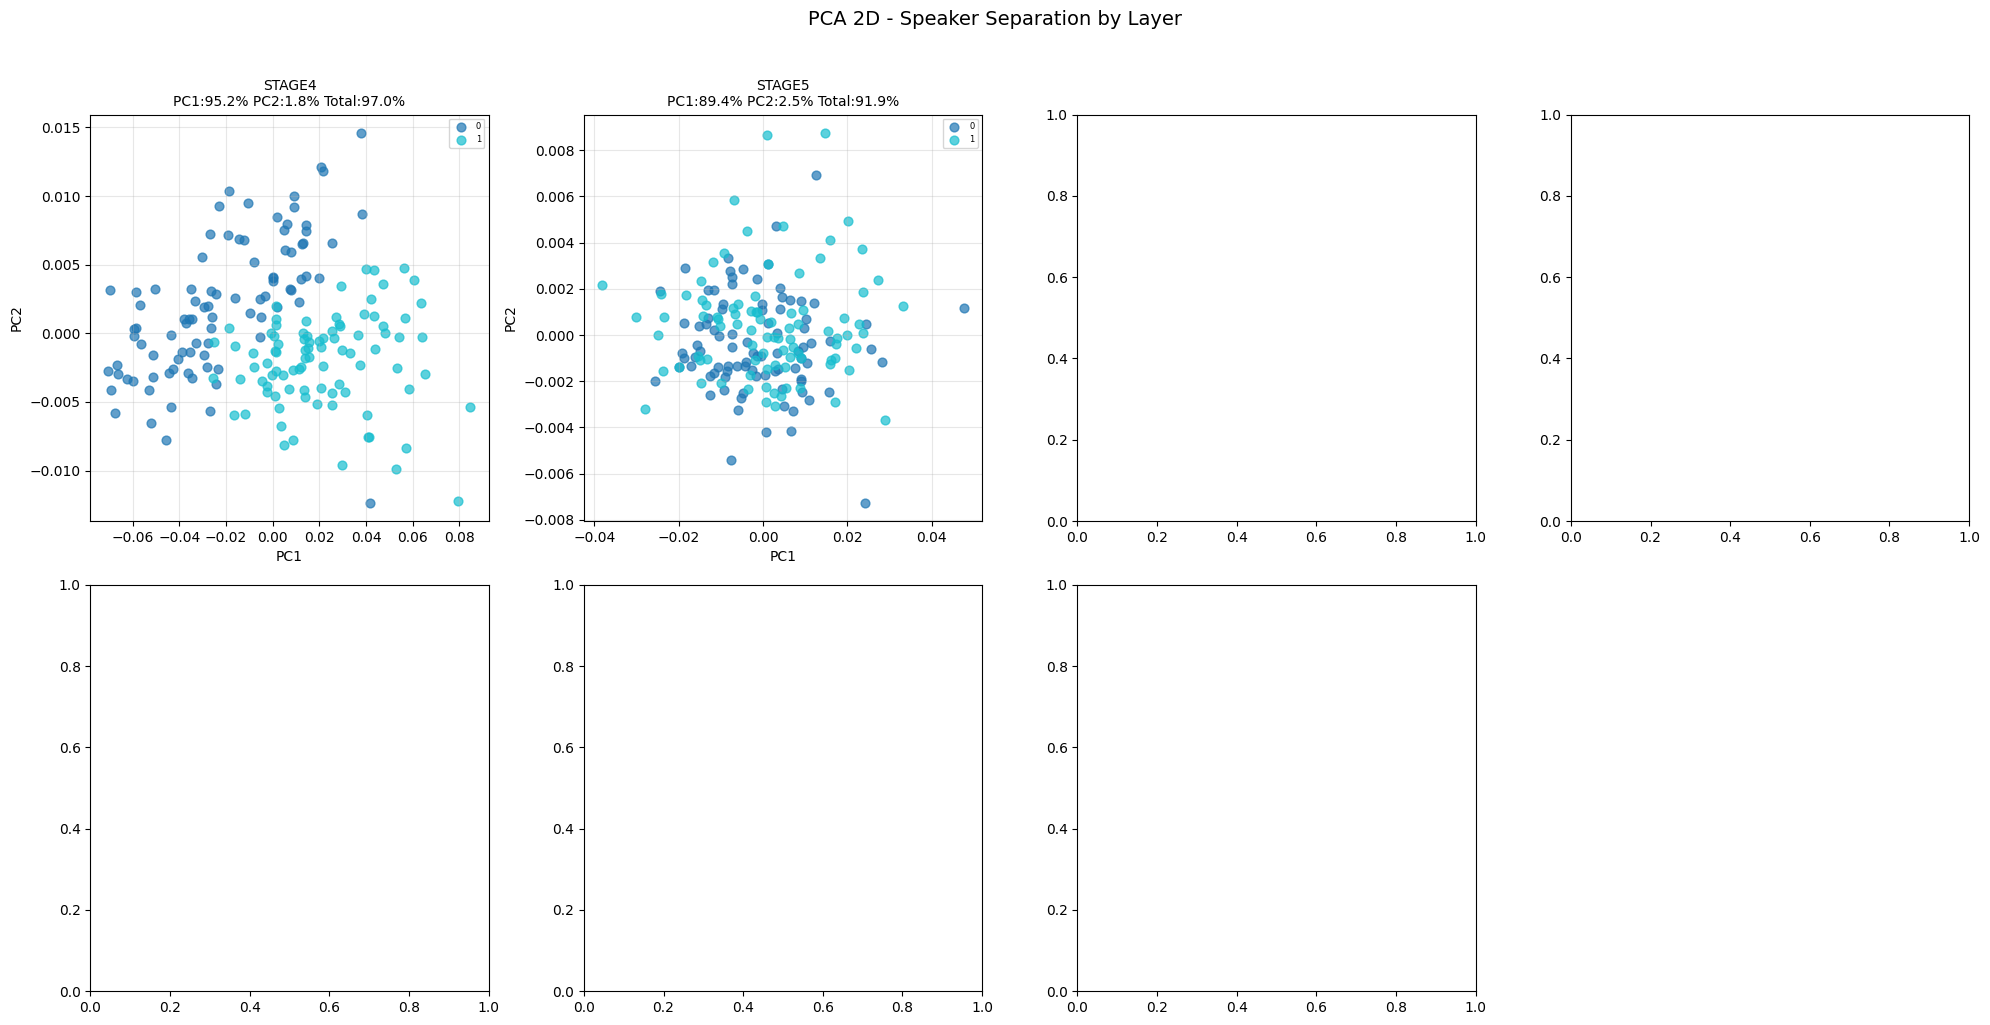

In [6]:
# PCA for all layers
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

pca_results = {}

for idx, layer in enumerate(layers):
    X = layer_data[layer]['X']
    y = layer_data[layer]['y']
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    evr = pca.explained_variance_ratio_
    pca_results[layer] = {'pca': pca, 'X_pca': X_pca, 'evr': evr}
    
    ax = axes[idx]
    labels = np.unique(y)
    colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))
    
    for i, lbl in enumerate(labels):
        mask = y == lbl
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], label=lbl, alpha=0.7, s=40)
    
    ax.set_title(f'{layer.upper()}\nPC1:{evr[0]*100:.1f}% PC2:{evr[1]*100:.1f}% Total:{evr.sum()*100:.1f}%', fontsize=10)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(fontsize=6, loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_visible(False)
plt.suptitle('PCA 2D - Speaker Separation by Layer', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
# Section 3: Which Concepts Represent Each Speaker?

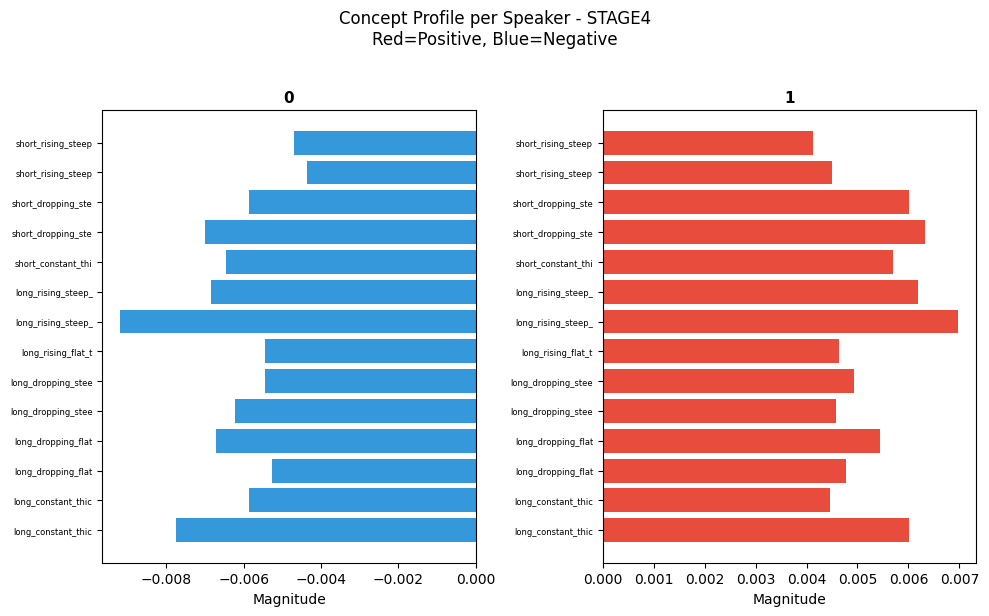

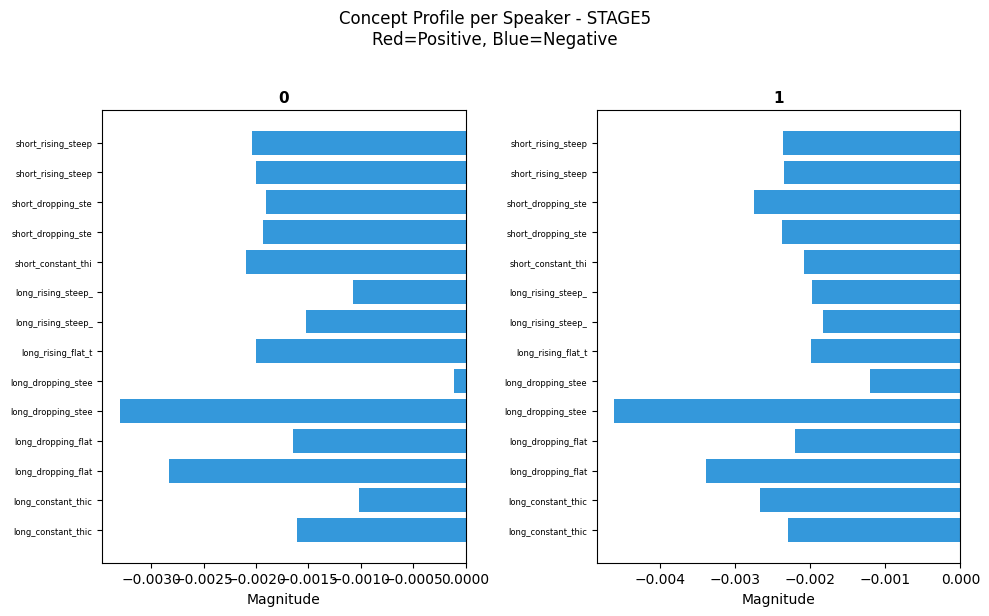

In [7]:
# Concept Profile per Speaker - ALL LAYERS
for layer in layers:
    vector_df = layer_data[layer]['df']
    speaker_table = vector_df.drop(columns=['path']).groupby('true label').mean()
    n_speakers = len(speaker_table.index)
    
    fig, axes = plt.subplots(1, n_speakers, figsize=(5*n_speakers, 6))
    if n_speakers == 1:
        axes = [axes]
    
    for idx, speaker in enumerate(speaker_table.index):
        ax = axes[idx]
        values = speaker_table.loc[speaker]
        colors = ['#e74c3c' if v > 0 else '#3498db' for v in values]
        ax.barh(range(len(values)), values.values, color=colors)
        ax.set_yticks(range(len(values)))
        ax.set_yticklabels([c[:18] for c in values.index], fontsize=6)
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.set_title(f'{speaker}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Magnitude')
    
    plt.suptitle(f'Concept Profile per Speaker - {layer.upper()}\nRed=Positive, Blue=Negative', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()


In [8]:
# Which speaker owns each concept? (STAGE4 - Best Layer)
best_layer = 'stage4'
vector_df = layer_data[best_layer]['df']
speaker_table = vector_df.drop(columns=['path']).groupby('true label').mean()

print(f"=== CONCEPT OWNERSHIP ({best_layer.upper()} - BEST LAYER) ===\n")
ownership = {}
for concept in speaker_table.columns:
    top_speaker = speaker_table[concept].idxmax()
    top_value = speaker_table[concept].max()
    ownership[concept] = top_speaker
    print(f"{concept[:30]:32s} → {top_speaker} ({top_value:.3f})")

ownership_df = pd.DataFrame({'Concept': list(ownership.keys()), 'Top Speaker': list(ownership.values())})
print("\n")
ownership_df

=== CONCEPT OWNERSHIP (STAGE4 - BEST LAYER) ===

long_constant_thick              → 1 (0.006)
long_constant_thick_Vibrato      → 1 (0.004)
long_dropping_flat_thick         → 1 (0.005)
long_dropping_flat_thick_Vibra   → 1 (0.005)
long_dropping_steep_thick        → 1 (0.005)
long_dropping_steep_thin         → 1 (0.005)
long_rising_flat_thick           → 1 (0.005)
long_rising_steep_thick          → 1 (0.007)
long_rising_steep_thin           → 1 (0.006)
short_constant_thick             → 1 (0.006)
short_dropping_steep_thick       → 1 (0.006)
short_dropping_steep_thin        → 1 (0.006)
short_rising_steep_thick         → 1 (0.004)
short_rising_steep_thin          → 1 (0.004)




,Concept,Top Speaker
0,long_constant_thick,1
1,long_constant_thick_Vibrato,1
2,long_dropping_flat_thick,1
3,long_dropping_flat_thick_Vibrato,1
4,long_dropping_steep_thick,1
5,long_dropping_steep_thin,1
6,long_rising_flat_thick,1
7,long_rising_steep_thick,1
8,long_rising_steep_thin,1
9,short_constant_thick,1


---
# Section 4: Clustering Metrics - Layer Comparison

In [9]:
# Compute metrics for all layers
def compute_metrics(X, y):
    n_clusters = len(np.unique(y))
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pred = kmeans.fit_predict(X)
    
    ari = adjusted_rand_score(y_enc, pred)
    sil = silhouette_score(X, pred, metric='cosine') if len(np.unique(pred)) > 1 else 0
    return {'ARI': ari, 'Silhouette': sil}

metrics = {}
for layer in layers:
    X = layer_data[layer]['X']
    y = layer_data[layer]['y']
    metrics[layer] = compute_metrics(X, y)

metrics_df = pd.DataFrame(metrics).round(4)
print("=== CLUSTERING METRICS BY LAYER ===")
metrics_df

=== CLUSTERING METRICS BY LAYER ===


,stage4,stage5
ARI,0.3050,0.0123
Silhouette,0.6617,0.4839


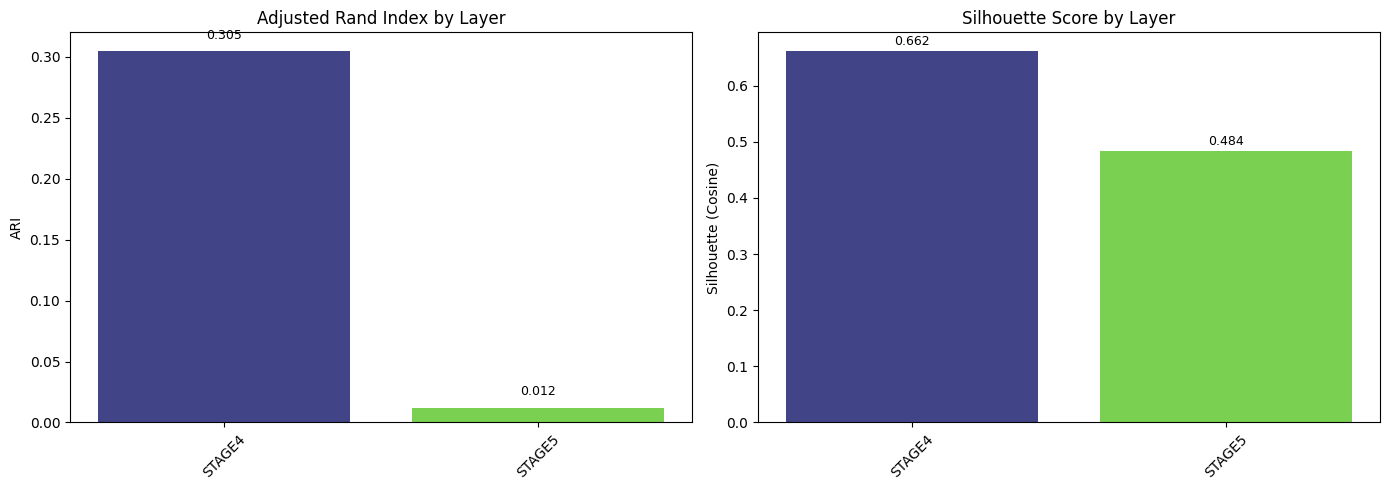

In [10]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(layers))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(layers)))

# ARI
ari_vals = [metrics[l]['ARI'] for l in layers]
bars1 = axes[0].bar(x, ari_vals, color=colors)
axes[0].set_xticks(x)
axes[0].set_xticklabels([l.upper() for l in layers], rotation=45)
axes[0].set_ylabel('ARI')
axes[0].set_title('Adjusted Rand Index by Layer', fontsize=12)
for i, v in enumerate(ari_vals):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# Silhouette
sil_vals = [metrics[l]['Silhouette'] for l in layers]
bars2 = axes[1].bar(x, sil_vals, color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels([l.upper() for l in layers], rotation=45)
axes[1].set_ylabel('Silhouette (Cosine)')
axes[1].set_title('Silhouette Score by Layer', fontsize=12)
for i, v in enumerate(sil_vals):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

---
# Section 5: PCA Variance Comparison

In [11]:
# PCA variance by layer
pca_variance = {}
for layer in layers:
    evr = pca_results[layer]['evr']
    pca_variance[layer] = {'PC1': evr[0], 'PC2': evr[1], 'Total': evr.sum()}

pca_df = pd.DataFrame(pca_variance).T * 100
pca_df = pca_df.round(2)
print("=== PCA VARIANCE EXPLAINED (%) ===")
pca_df

=== PCA VARIANCE EXPLAINED (%) ===


,PC1,PC2,Total
stage4,95.18,1.78,96.96
stage5,89.42,2.51,91.92


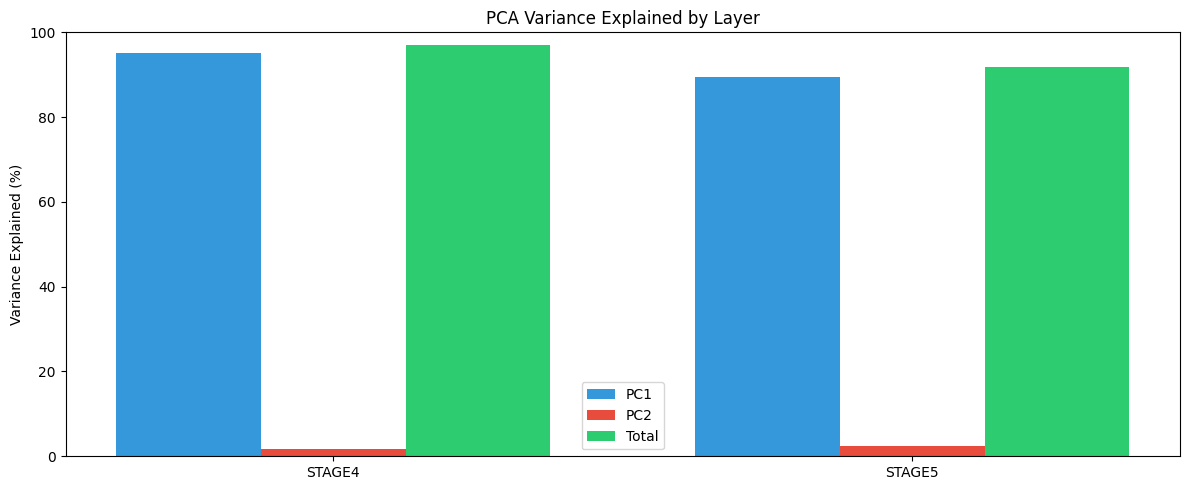

In [12]:
# Variance bar chart
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(layers))
width = 0.25

ax.bar(x - width, pca_df['PC1'], width, label='PC1', color='#3498db')
ax.bar(x, pca_df['PC2'], width, label='PC2', color='#e74c3c')
ax.bar(x + width, pca_df['Total'], width, label='Total', color='#2ecc71')

ax.set_xticks(x)
ax.set_xticklabels([l.upper() for l in layers])
ax.set_ylabel('Variance Explained (%)')
ax.set_title('PCA Variance Explained by Layer')
ax.legend()
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

---
# FINAL SUMMARY

In [13]:
print("="*70)
print("                    FINAL SUMMARY                    ")
print("="*70)

# Best layer by ARI
best_ari_layer = max(metrics, key=lambda x: metrics[x]['ARI'])
best_ari = metrics[best_ari_layer]['ARI']

# Best layer by Silhouette
best_sil_layer = max(metrics, key=lambda x: metrics[x]['Silhouette'])
best_sil = metrics[best_sil_layer]['Silhouette']

# Best PCA variance
best_pca_layer = pca_df['Total'].idxmax()
best_pca = pca_df.loc[best_pca_layer, 'Total']

print(f"\n  Best ARI:        {best_ari_layer.upper()} ({best_ari:.4f})")
print(f"  Best Silhouette: {best_sil_layer.upper()} ({best_sil:.4f})")
print(f"  Best PCA:        {best_pca_layer.upper()} ({best_pca:.1f}% variance)")

print("\n" + "="*70)
print(f"  CONCLUSION: {best_ari_layer.upper()} layer best separates speakers")
print("="*70)

                    FINAL SUMMARY                    

  Best ARI:        STAGE4 (0.3050)
  Best Silhouette: STAGE4 (0.6617)
  Best PCA:        STAGE4 (97.0% variance)

  CONCLUSION: STAGE4 layer best separates speakers


In [14]:
# Full metrics table
print("\n=== FULL METRICS TABLE ===")
full_df = pd.concat([metrics_df.T, pca_df], axis=1)
full_df.columns = ['ARI', 'Silhouette', 'PC1 %', 'PC2 %', 'Total %']
full_df = full_df.round(4)
full_df


=== FULL METRICS TABLE ===


,ARI,Silhouette,PC1 %,PC2 %,Total %
stage4,0.3050,0.6617,95.18,1.78,96.96
stage5,0.0123,0.4839,89.42,2.51,91.92


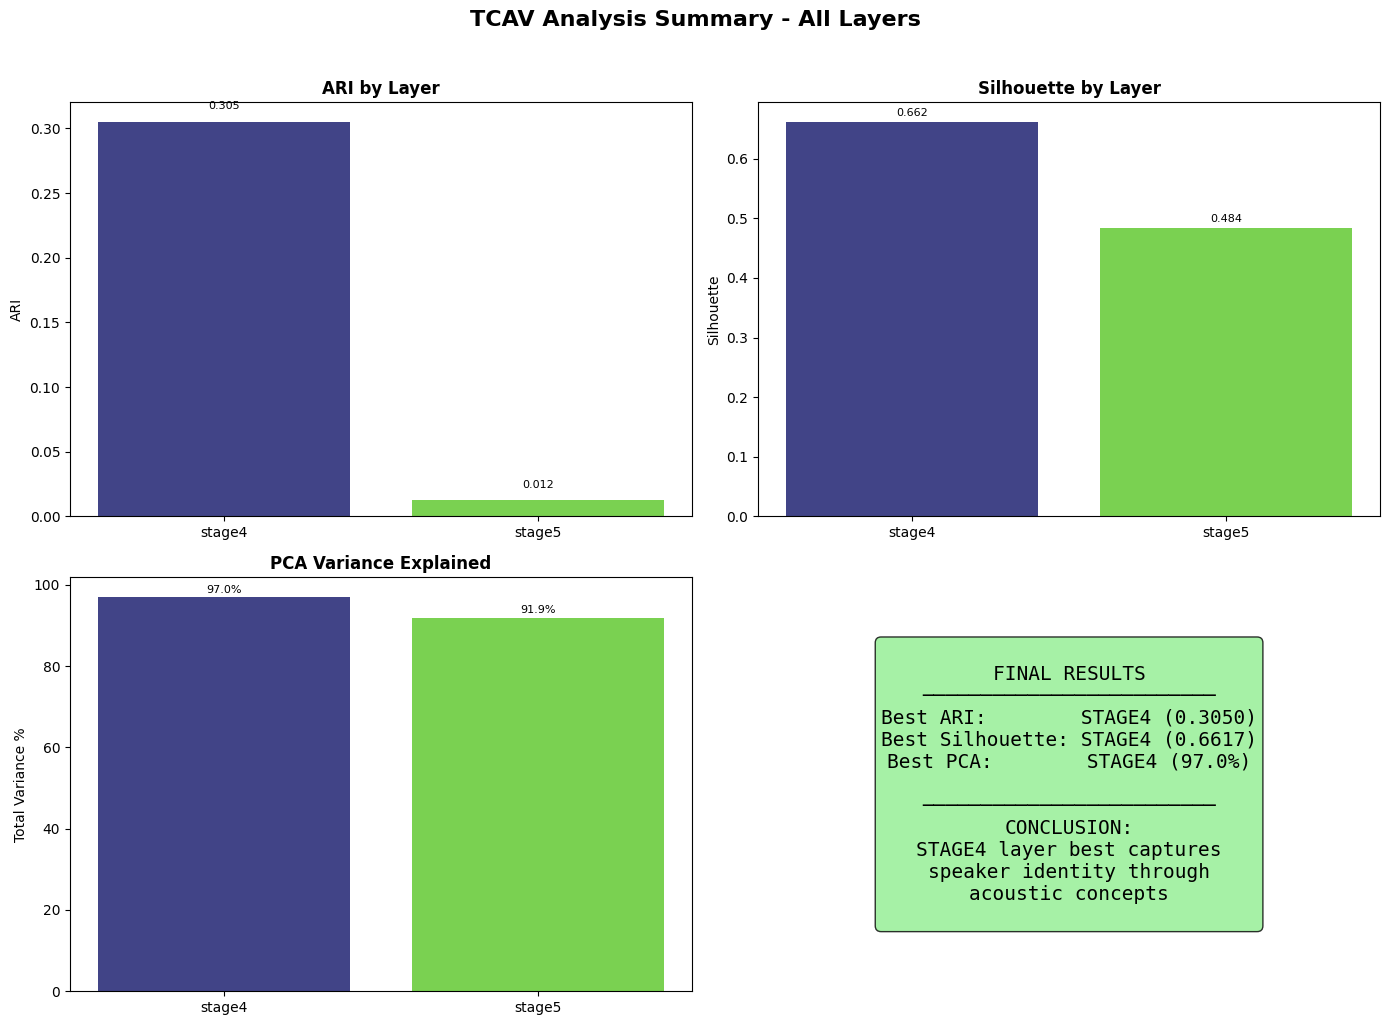


All plots saved to tcav/ folder!


In [15]:
# Save summary plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ARI comparison
axes[0,0].bar(layers, ari_vals, color=colors)
axes[0,0].set_title('ARI by Layer', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('ARI')
for i, v in enumerate(ari_vals):
    axes[0,0].text(i, v+0.01, f'{v:.3f}', ha='center', fontsize=8)

# 2. Silhouette comparison
axes[0,1].bar(layers, sil_vals, color=colors)
axes[0,1].set_title('Silhouette by Layer', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Silhouette')
for i, v in enumerate(sil_vals):
    axes[0,1].text(i, v+0.01, f'{v:.3f}', ha='center', fontsize=8)

# 3. PCA variance
axes[1,0].bar(layers, pca_df['Total'], color=colors)
axes[1,0].set_title('PCA Variance Explained', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Total Variance %')
for i, v in enumerate(pca_df['Total']):
    axes[1,0].text(i, v+1, f'{v:.1f}%', ha='center', fontsize=8)

# 4. Summary text
axes[1,1].axis('off')
summary_text = f"""
FINAL RESULTS
─────────────────────────
Best ARI:        {best_ari_layer.upper()} ({best_ari:.4f})
Best Silhouette: {best_sil_layer.upper()} ({best_sil:.4f})
Best PCA:        {best_pca_layer.upper()} ({best_pca:.1f}%)

─────────────────────────
CONCLUSION:
{best_ari_layer.upper()} layer best captures
speaker identity through
acoustic concepts
"""
axes[1,1].text(0.5, 0.5, summary_text, transform=axes[1,1].transAxes,
               fontsize=14, verticalalignment='center', horizontalalignment='center',
               fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.suptitle('TCAV Analysis Summary - All Layers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nAll plots saved to tcav/ folder!")

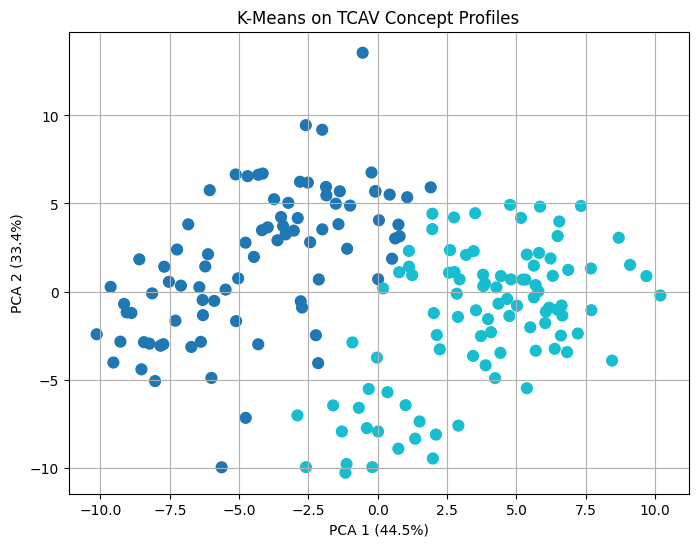

In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv(csv_path)

# Choose features to cluster on
FEATURES = ["positive percentage", "magnitude", "cav acc"]

# Build a single feature per (concept, layer)
df["feature_name"] = df["layer_key"] + "::" + df["concept name"]

# Pivot → one row per sample, columns = TCAV features
X = df.pivot_table(
    index="path", columns="feature_name", values=FEATURES, aggfunc="mean"
)

# Flatten multi-index columns
X.columns = [f"{a}|{b}" for a, b in X.columns]
X = X.fillna(0.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = df["true label"].nunique()

kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)

clusters = kmeans.fit_predict(X_scaled)

X_out = X.copy()
X_out["cluster"] = clusters
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="tab10", s=60)

plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("K-Means on TCAV Concept Profiles")
plt.grid(True)
plt.show()

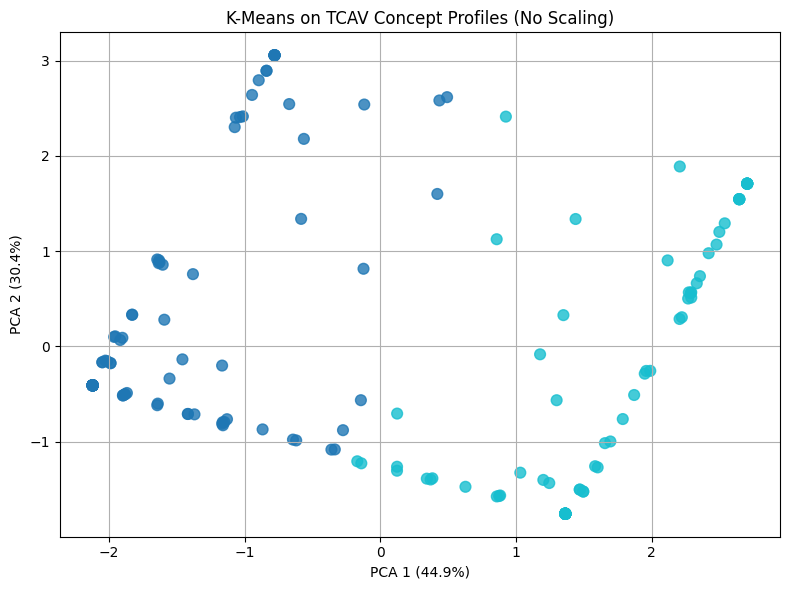

In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv(csv_path)

# Features to use
FEATURES = ["positive percentage", "magnitude", "cav acc"]

# Build feature name per (layer, concept)
df["feature_name"] = df["layer_key"] + "::" + df["concept name"]

# Pivot: one row per audio file (path), columns = TCAV features
X = df.pivot_table(
    index="path", columns="feature_name", values=FEATURES, aggfunc="mean"
)

# Flatten columns and handle missing values
X.columns = [f"{a}|{b}" for a, b in X.columns]
X = X.fillna(0.0)

# Number of clusters = number of true speakers
k = df["true label"].nunique()

# K-Means (no scaling)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)

clusters = kmeans.fit_predict(X.values)

# Attach clusters
X_out = X.copy()
X_out["cluster"] = clusters

# PCA for visualization only
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="tab10", s=60, alpha=0.8)

plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("K-Means on TCAV Concept Profiles (No Scaling)")
plt.grid(True)
plt.tight_layout()
plt.show()

speaker,0,1
cluster,,
0,24,71
1,66,19


,dominant_speaker,dominant_percentage
cluster,,
0,1,0.747368
1,0,0.776471


Mean cluster purity: 76.19%
ARI: 0.269
NMI: 0.208


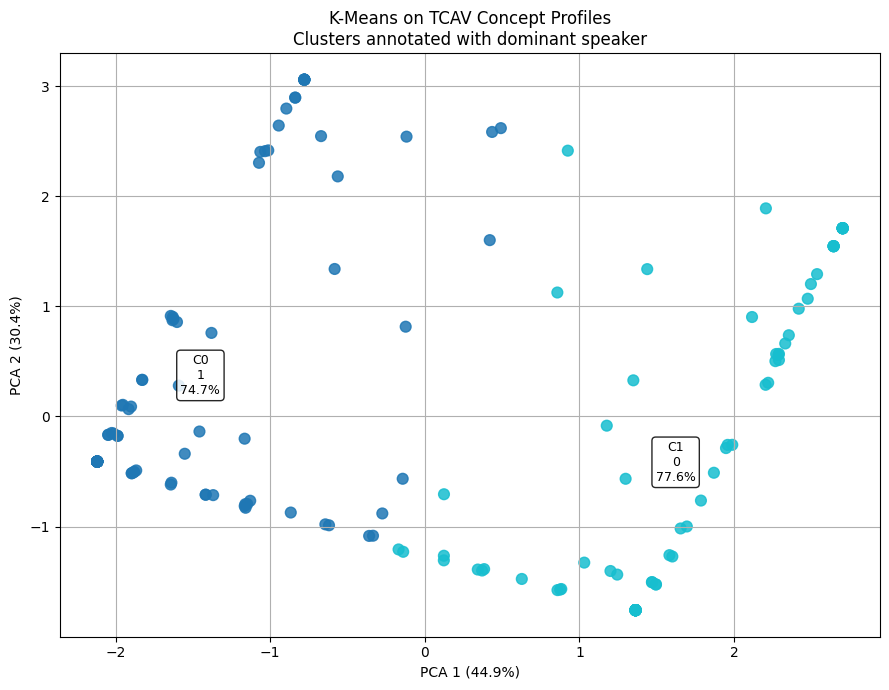

In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt

# ======================
# Load CSV
# ======================
df = pd.read_csv(csv_path)

FEATURES = ["positive percentage", "magnitude", "cav acc"]

# Build feature name per (layer, concept)
df["feature_name"] = df["layer_key"] + "::" + df["concept name"]

# Pivot: one row per audio file (path)
X = df.pivot_table(
    index="path", columns="feature_name", values=FEATURES, aggfunc="mean"
)

# Flatten columns and fill missing
X.columns = [f"{a}|{b}" for a, b in X.columns]
X = X.fillna(0.0)

# ======================
# K-Means
# ======================
k = df["true label"].nunique()

kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)

clusters = kmeans.fit_predict(X.values)

X_out = X.copy()
X_out["cluster"] = clusters

# ======================
# Speaker labels (from true label, safer than path)
# ======================
speaker_map = (
    df[["path", "true label"]].drop_duplicates().set_index("path")["true label"]
)

X_out["speaker"] = X_out.index.map(speaker_map)

# ======================
# Cluster ↔ Speaker table
# ======================
cluster_speaker_table = (
    X_out.groupby(["cluster", "speaker"]).size().unstack(fill_value=0)
)

display(cluster_speaker_table)

# ======================
# Cluster purity (dominant speaker per cluster)
# ======================
cluster_purity = cluster_speaker_table.div(cluster_speaker_table.sum(axis=1), axis=0)

dominant_speaker = cluster_purity.idxmax(axis=1)
dominant_percentage = cluster_purity.max(axis=1)

cluster_summary = pd.DataFrame(
    {"dominant_speaker": dominant_speaker, "dominant_percentage": dominant_percentage}
)

display(cluster_summary)

# ======================
# Global score (mean cluster purity)
# ======================
mean_cluster_purity = dominant_percentage.mean()
print(f"Mean cluster purity: {mean_cluster_purity*100:.2f}%")

# ======================
# ARI / NMI
# ======================
y_true = X_out["speaker"]
y_pred = X_out["cluster"]

ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

# ======================
# PCA for visualization
# ======================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

plt.figure(figsize=(9, 7))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=X_out["cluster"], cmap="tab10", s=60, alpha=0.85
)

# Annotate cluster centers with dominant speaker + purity
centers_pca = pca.transform(kmeans.cluster_centers_)
for cluster_id, (x, y) in zip(dominant_speaker.index, centers_pca):
    label = (
        f"C{cluster_id}\n"
        f"{dominant_speaker.loc[cluster_id]}\n"
        f"{dominant_percentage.loc[cluster_id]*100:.1f}%"
    )
    plt.text(
        x,
        y,
        label,
        fontsize=9,
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.85),
    )

plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("K-Means on TCAV Concept Profiles\nClusters annotated with dominant speaker")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# ======================
# Classification-style correctness (cluster -> dominant speaker)
# ======================

# 1) Predict speaker for each sample by taking the dominant speaker of its cluster
pred_speaker = X_out["cluster"].map(dominant_speaker)

X_out["pred_speaker"] = pred_speaker
X_out["correct"] = (X_out["pred_speaker"] == X_out["speaker"])

# 2) Overall "separation %" = accuracy of this mapping
overall_acc = X_out["correct"].mean()

# 3) Per-speaker accuracy
per_speaker_acc = (
    X_out.groupby("speaker")["correct"].mean().rename("speaker_acc")
)

# 4) Weighted purity (often a nicer single number than mean purity)
cluster_sizes = cluster_speaker_table.sum(axis=1).rename("cluster_size")
weighted_purity = (dominant_percentage * cluster_sizes).sum() / cluster_sizes.sum()

print(f"\n=== CLASSIFICATION-STYLE RESULTS ===")
print(f"Overall accuracy (cluster -> dominant speaker): {overall_acc*100:.2f}%")
print(f"Weighted purity: {weighted_purity*100:.2f}%")

# 5) Add per-cluster accuracy + size into cluster_summary
cluster_correct_rate = (
    X_out.groupby("cluster")["correct"].mean().rename("cluster_acc")
)

cluster_summary_aug = (
    cluster_summary
    .join(cluster_sizes)
    .join(cluster_correct_rate)
    .sort_index()
    .drop(columns=["dominant_percentage"])
    
)
#make in cluster_summary_aug the dominant_speaker to be unique
cluster_summary_aug['dominant_speaker'] = cluster_summary_aug['dominant_speaker'].astype(str)

print("\n=== CLUSTER SUMMARY (with accuracy) ===")
display(cluster_summary_aug)

print("\n=== PER-SPEAKER ACCURACY ===")
display((per_speaker_acc * 100).round(2).to_frame())

# 6) (Optional) Confusion table: true speaker vs predicted speaker
conf = pd.crosstab(X_out["speaker"], X_out["pred_speaker"], rownames=["true"], colnames=["pred"])
print("\n=== CONFUSION (true vs predicted speaker) ===")
display(conf)



=== CLASSIFICATION-STYLE RESULTS ===
Overall accuracy (cluster -> dominant speaker): 76.11%
Weighted purity: 76.11%

=== CLUSTER SUMMARY (with accuracy) ===


,dominant_speaker,cluster_size,cluster_acc
cluster,,,
0,1,95,0.747368
1,0,85,0.776471



=== PER-SPEAKER ACCURACY ===


,speaker_acc
speaker,
0,73.33
1,78.89



=== CONFUSION (true vs predicted speaker) ===


pred,0,1
true,,
0,66,24
1,19,71
